In [152]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import json
from pprint import pprint
import re

In [ ]:
def is_conservative(s):
    # Define the pattern for "(union|intersection|setminus) X.[RL] X.[RL]"
    pattern_main = r'(union|intersection|setminus) X\.[RL] X\.[RL]'
    
    # Find all occurrences of this pattern
    main_matches = re.findall(pattern_main, s)
    
    # Remove the matched main pattern from the string to check for the presence of X.R or X.L exclusively
    s_without_main = re.sub(pattern_main, '', s)
    
    # Check for exclusive presence of X.R or X.L in the rest of the string
    x_r_matches = re.findall(r'X\.R', s_without_main)
    x_l_matches = re.findall(r'X\.L', s_without_main)
    
    # Both X.R and X.L should not be present together
    # This returns False if either both are present or both are absent
    if bool(x_r_matches) == bool(x_l_matches):  
        return False
    
    # If all conditions are met, the string is conservative
    return len(main_matches)>0 

In [239]:
# Example usage
test_string = "This is an intersection X.R X.L example with X.R only X.L."
print(is_conservative(test_string))

False


In [8]:
datadir = "./../../data/first_test/"

In [187]:
data = []
for findex in range(1,17):
    fpath = "./../../data/first_test/run_"+str(findex)
    run = dict()
    with open(fpath+'/parameters.json','r') as openf:
        params = json.load(openf)
        run['params'] = params
    run['generation'] = []
    for genindex in range(200):
        try:
            with open(f'{fpath}/generation_{genindex}.json') as openf:
                run['generation'].append(json.load(openf))
        except FileNotFoundError:
            pass
    data.append(run)

In [290]:
reshuffled_data = []
for expi, exp in enumerate(data):
    for geni, gen in enumerate(exp['generation']):
        for childi, child in enumerate(gen['children']):
            original = None
            try:
                original = child['originalHypothesis']
            except:
                pass
            reshuffled_data.append({
                'exp': expi,
                'gen': geni,
                'child': childi,
                'hyp': child['hypothesis'],
                'commAcc': child['commAcc'],
                'parent': child['parentIndex'] if geni>0 else None,
                'original': original
            })
reshuffled_data = pd.DataFrame(reshuffled_data)
reshuffled_data[['comp', 'Q1', 'Q2', 'Q3']] = reshuffled_data.hyp.str.split('|',expand=True)

In [291]:
reshuffled_data = reshuffled_data[reshuffled_data['gen']<=86]

In [292]:
reshuffled_data['conservative'] = reshuffled_data.comp.apply(is_conservative)

In [293]:
reshuffled_data

,exp,gen,child,hyp,commAcc,parent,original,comp,Q1,Q2,Q3,conservative
0,0,0,0,λx.( intGt ( cardinality X.L X.c ) 0 ) | ( int...,-156.113221,NaN,None,λx.( intGt ( cardinality X.L X.c ) 0 ),( intEq ( cardinality X.R X.c ) ( + ( cardina...,( intGt ( cardinality X.L X.c ) 1 ),( intGt ( cardinality X.R X.c ) ( cardinality...,False
1,0,0,1,λx.( ( X.Q ( nTh ( cardinality ( setminus X.L ...,-130.762340,NaN,None,λx.( ( X.Q ( nTh ( cardinality ( setminus X.L ...,( intEq ( + 0 ( cardinality X.R X.c ) ) ( car...,( intEq 0 ( + ( cardinality X.L X.c ) ( + ( c...,( intGt ( cardinality X.L X.c ) 0 ),True
2,0,0,2,λx.( intGt ( + ( cardinality X.R X.c ) ( cardi...,-153.278958,NaN,None,λx.( intGt ( + ( cardinality X.R X.c ) ( cardi...,( intGt ( - 0 ( cardinality X.L X.c ) ) ( car...,( and ( intEq 0 ( - ( cardinality ( intersect...,( intGt ( cardinality X.L X.c ) ( cardinality...,False
3,0,0,3,λx.( intGt 0 ( - 0 ( cardinality X.R X.c ) ) )...,-163.541746,NaN,None,λx.( intGt 0 ( - 0 ( cardinality X.R X.c ) ) ),( intEq ( cardinality X.R X.c ) 0 ),( intEq 0 ( cardinality X.L X.c ) ),( intEq 0 ( cardinality X.L X.c ) ),False
4,0,0,4,λx.( ( X.Q X.L ) X.R ) | ( and ( and ( intEq (...,-165.213307,NaN,None,λx.( ( X.Q X.L ) X.R ),( and ( and ( intEq ( cardinality ( union X.R...,( intGt ( cardinality ( union X.L X.L ) X.c )...,( intGt ( cardinality X.L X.c ) ( cardinality...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
15135,15,86,5,λx.( intGt 1 0 ) | ( intGt ( cardinality X.R X...,-156.057526,7.0,None,λx.( intGt 1 0 ),( intGt ( cardinality X.R X.c ) ( cardinality...,( intGt ( cardinality X.L X.c ) ( cardinality...,( intGt ( cardinality X.L X.c ) ( cardinality...,False
15136,15,86,6,λx.( intEq 0 0 ) | ( intEq ( cardinality X.L X...,-166.454734,0.0,None,λx.( intEq 0 0 ),( intEq ( cardinality X.L X.c ) ( cardinality...,( intGt ( cardinality X.R X.c ) ( cardinality...,( intEq ( cardinality X.R X.c ) ( cardinality...,False
15137,15,86,7,λx.( ( X.Q X.R ) X.R ) | ( intEq ( cardinality...,-166.454734,7.0,None,λx.( ( X.Q X.R ) X.R ),( intEq ( cardinality X.L X.c ) ( cardinality...,( intEq ( cardinality X.L X.c ) ( cardinality...,( intEq ( cardinality X.L X.c ) ( cardinality...,False
15138,15,86,8,λx.( ( X.Q X.L ) X.L ) | ( intEq ( cardinality...,-159.394185,0.0,None,λx.( ( X.Q X.L ) X.L ),( intEq ( cardinality X.L X.c ) ( cardinality...,( intEq ( cardinality X.R X.c ) ( cardinality...,( intEq ( cardinality X.L X.c ) ( cardinality...,False


In [294]:
reshuffled_data.groupby(['gen','exp']).conservative.sum().reset_index()

,gen,exp,conservative
0,0,0,1
1,0,1,1
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
1387,86,11,1
1388,86,12,1
1389,86,13,4
1390,86,14,0


<Axes: xlabel='commAcc', ylabel='Density'>

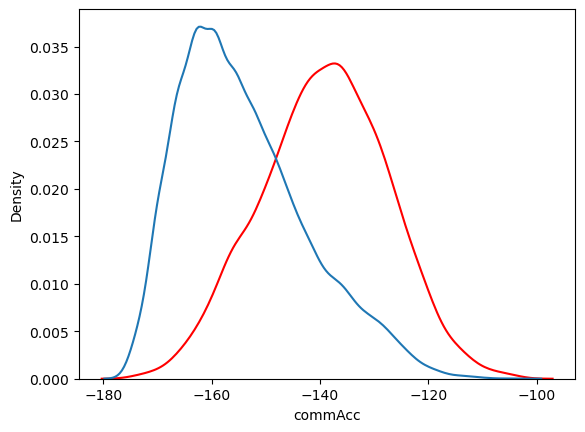

In [295]:
sns.kdeplot(reshuffled_data.commAcc[reshuffled_data.conservative], color='red')
sns.kdeplot(reshuffled_data.commAcc[np.logical_not(reshuffled_data.conservative)])

<Axes: xlabel='gen', ylabel='conservative'>

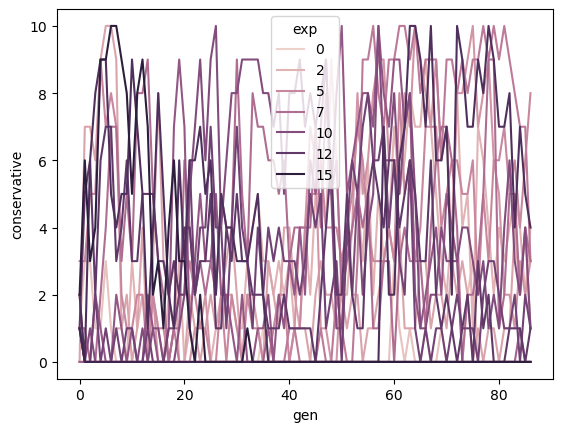

In [244]:
sns.lineplot(
    reshuffled_data.groupby(['gen','exp']).conservative.sum().reset_index(),
    x='gen',
    y='conservative',
    hue='exp'
)
# plt.plot(reshuffled_data.groupby('gen').size())

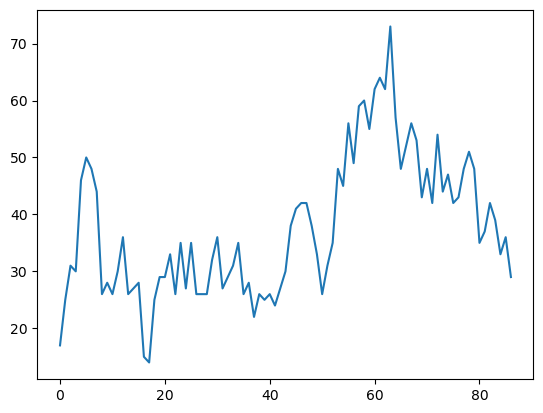

In [250]:
plt.plot(reshuffled_data.groupby(['gen']).conservative.sum())

In [245]:
print(is_conservative('λx.( not ( ( X.Q ( intersection X.L X.R ) ) X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( union X.R X.L ) ) X.R ) ) '))
print(is_conservative('λx.( ( X.Q X.L ) ( setminus X.L X.R ) ) '))
print(is_conservative('λx.( ( X.Q X.L ) ( union X.L X.R ) ) '))
print(is_conservative('λx.( ( X.Q X.L ) ( union X.R X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( setminus X.L X.R ) ) X.L ) ) '))

True
True
True
True
True
True


In [196]:
def calculate_unique(x):
    y, counts = np.unique(x.comp,return_counts=True)
    print(y)
    return y

reshuffled_data.groupby(['gen']).apply(calculate_unique)

['λx.( ( X.Q ( intersection X.L X.R ) ) X.R ) '
 'λx.( ( X.Q ( nTh ( cardinality ( setminus X.L X.R ) X.c ) X.c X.R ) ) X.R ) '
 'λx.( ( X.Q ( nTh 0 X.c X.L ) ) X.L ) '
 'λx.( ( X.Q ( nTh 1 X.c X.R ) ) X.R ) '
 'λx.( ( X.Q ( setminus X.L X.L ) ) X.L ) '
 'λx.( ( X.Q ( setminus X.L X.L ) ) X.R ) '
 'λx.( ( X.Q ( union X.R X.L ) ) X.L ) '
 'λx.( ( X.Q ( union X.R X.R ) ) X.L ) '
 'λx.( ( X.Q X.L ) ( intersection X.L X.L ) ) '
 'λx.( ( X.Q X.L ) ( nTh 0 X.c X.L ) ) '
 'λx.( ( X.Q X.L ) ( setminus ( nTh 0 X.c X.R ) X.R ) ) '
 'λx.( ( X.Q X.L ) ( setminus X.L X.L ) ) ' 'λx.( ( X.Q X.L ) X.L ) '
 'λx.( ( X.Q X.L ) X.R ) '
 'λx.( ( X.Q X.R ) ( nTh ( cardinality X.R X.c ) X.c X.R ) ) '
 'λx.( ( X.Q X.R ) ( nTh 1 X.c X.R ) ) '
 'λx.( ( X.Q X.R ) ( union ( intersection X.R X.L ) X.R ) ) '
 'λx.( ( X.Q X.R ) ( union X.L X.L ) ) ' 'λx.( ( X.Q X.R ) X.L ) '
 'λx.( ( X.Q X.R ) X.R ) '
 'λx.( and ( and ( intEq 0 0 ) ( intEq 0 1 ) ) ( intEq ( cardinality X.R X.c ) ( - ( cardinality X.L X.c ) 1 ) ) ) '

gen
0     [λx.( ( X.Q ( intersection X.L X.R ) ) X.R ) ,...
1     [λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) ,...
2     [λx.( ( X.Q ( intersection X.R X.L ) ) X.L ) ,...
3     [λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) ,...
4     [λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) ,...
                            ...                        
82    [λx.( ( X.Q ( intersection X.L X.R ) ) ( setmi...
83    [λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) ,...
84    [λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) ,...
85    [λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) ,...
86    [λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) ,...
Length: 87, dtype: object

In [300]:
df_plot = reshuffled_data[reshuffled_data['exp']==10][['gen','child','parent','comp','conservative','commAcc','original']]

(-2.0, 87.0)

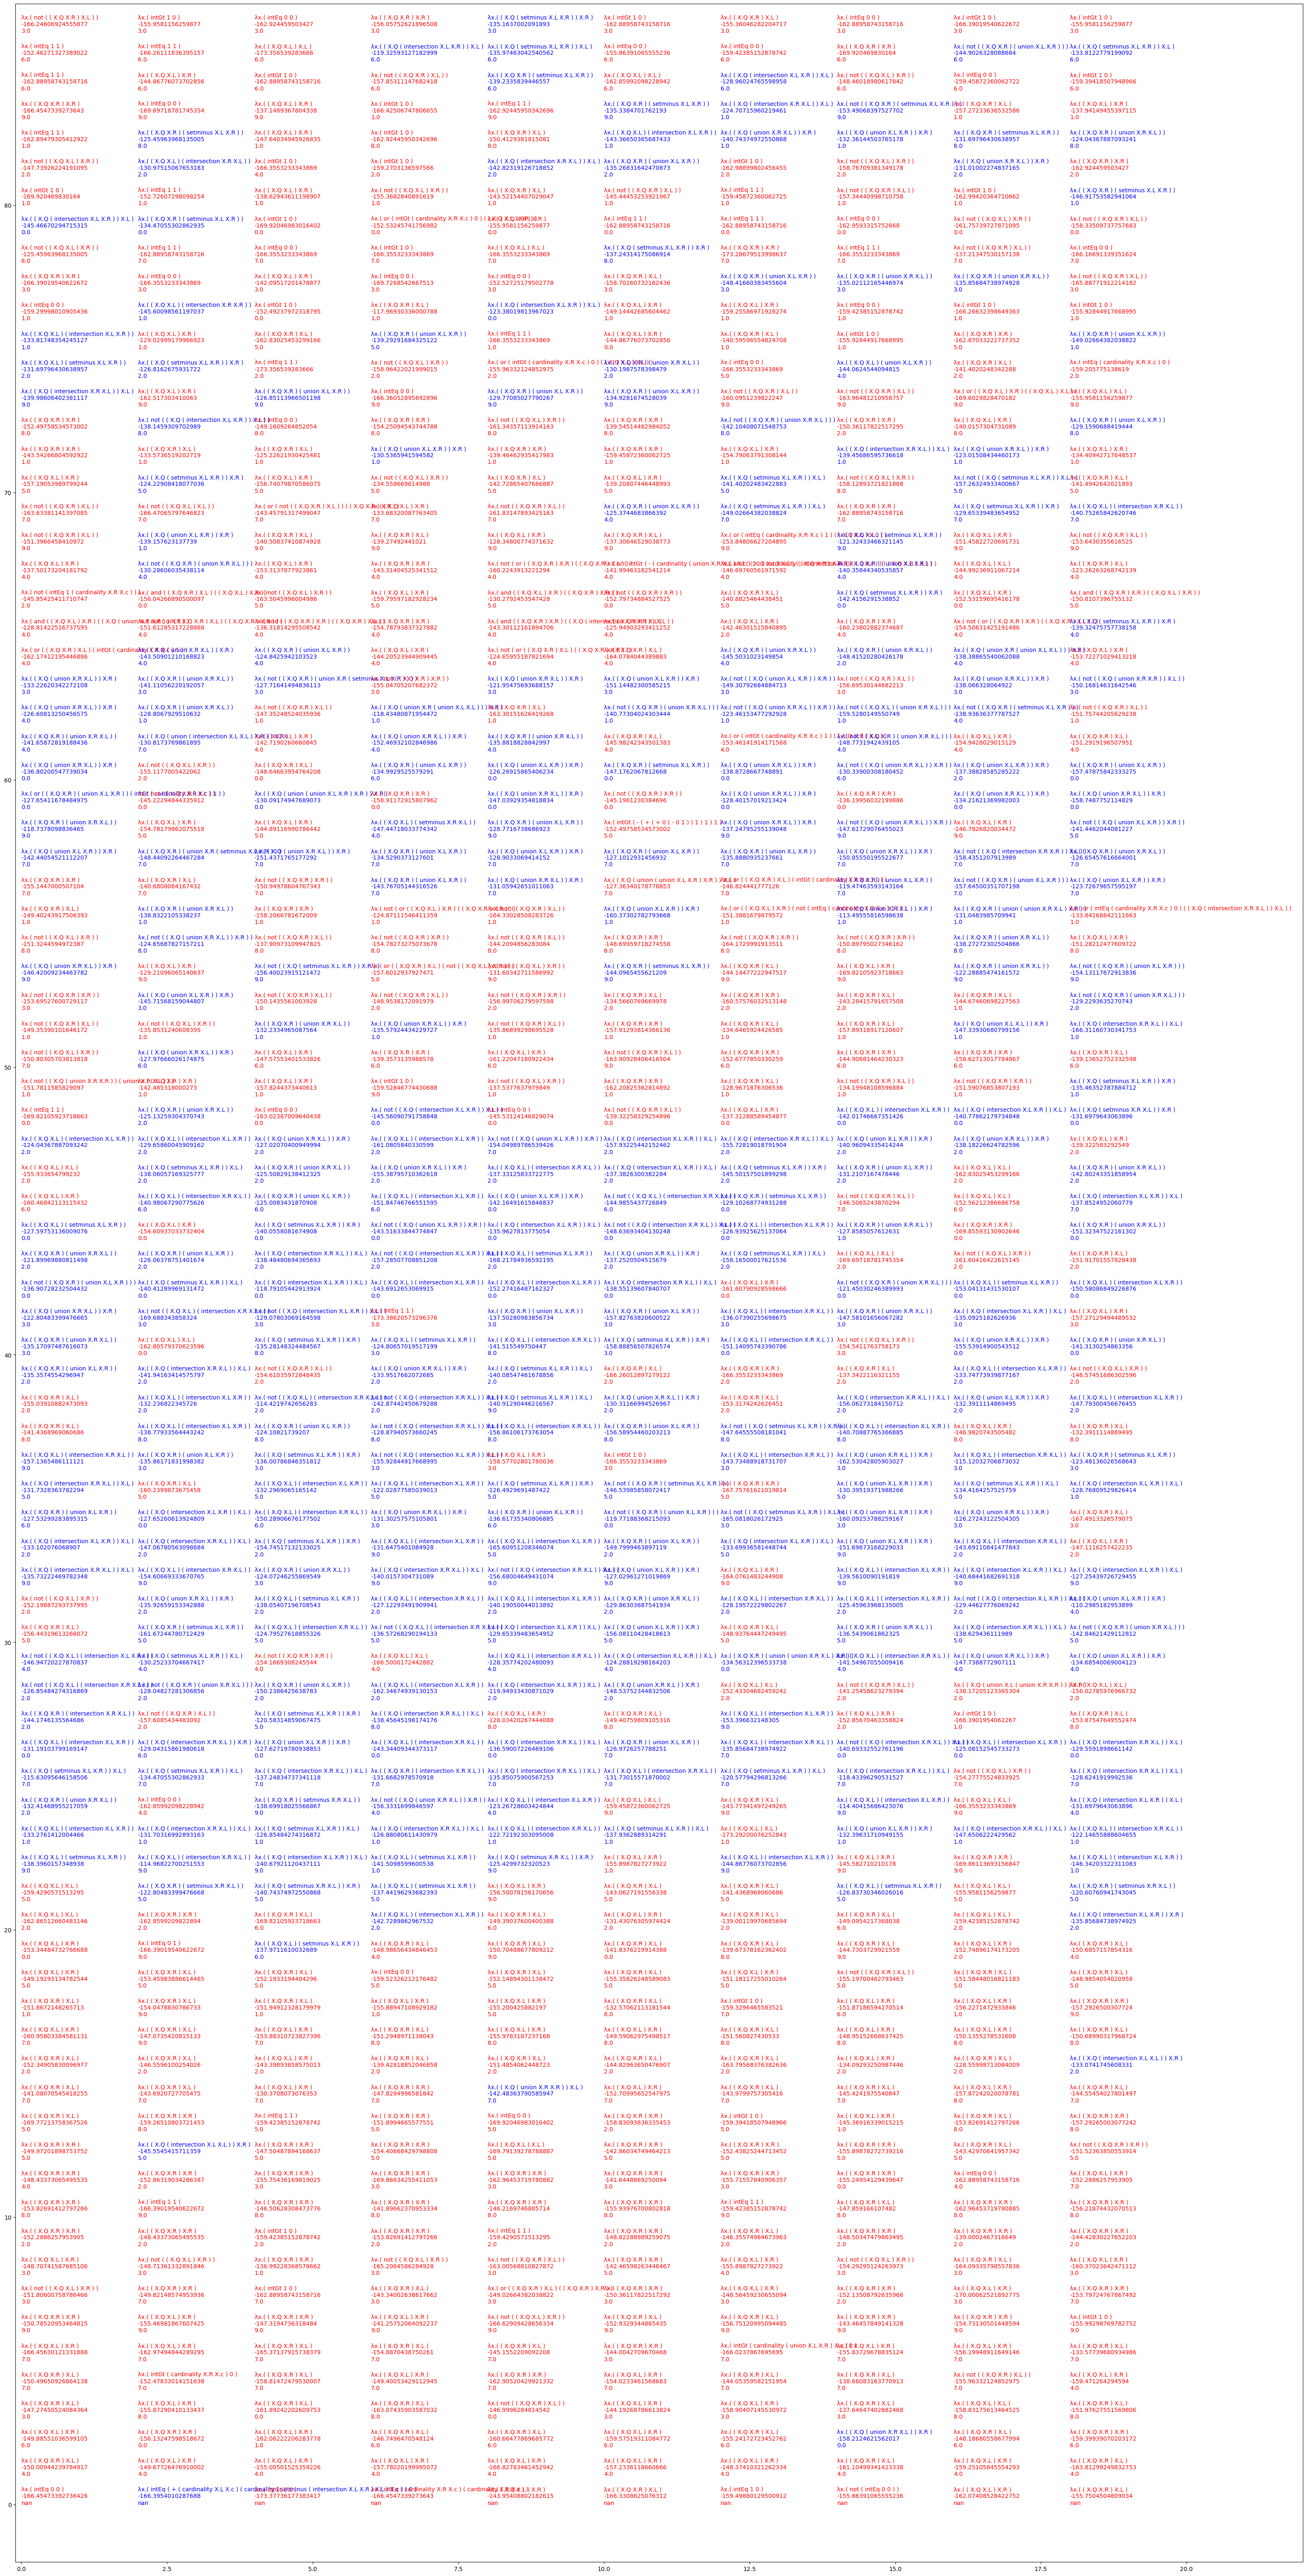

In [303]:
fig,ax = plt.subplots(figsize=(40,80))
for i, agent in df_plot.iterrows():
    color = 'blue' if agent.conservative else 'red'
    ax.text(
        agent.child*2, 
        agent.gen, 
        agent['comp']+'\n'
        # +(agent.original if agent.original else '')
        +str(agent.commAcc)
        +'\n'+str(agent.parent),
        color=color
    )
ax.set_xlim(-0.1,22)
ax.set_ylim(-2,df_plot.gen.max()+1)